<a href="https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/main/TEMPLATE_Probabilistic_Machine_Learning_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (SoSe 2025)
**Lecturer:** Dr. Alvaro Diaz-Ruelas  
**Student(s) Name(s):**  Jeremias Fichtner
**GitHub Username(s):**  Jeremoya
**Date:**  09/06/2025
**PROJECT-ID:** 16-1FJXXXX_time_series_vegetation

---


## 1. Introduction

#### Brief description of the dataset and problem

The dataset is remotely sensed time series data consisting of time series for **5 different variables** (air temperature, evaporation, precipitation, radiation, kNDVI (Kernel Normalized Difference Vegetation Index, (https://doi.org/10.1126/sciadv.abc7447))) which has been collected for approximately **280'000 pixels** over a time span of **21 years** in **intervalls of 8 days**, which makes for a total of **1004 timesteps** (shape: [280'000, 1004, 5] with the dimensions [pixel,  time, variable]). The data is shuffled so that no spatial information is retained, only temporal. The goal is to make a timeseries prediction on the kNDVI variable using one or multiple models and to to assess its quality. There is also a small subset of the data where the kNDVI was not collected, and for this the missing values could be added, given a sufficient performance of the model.

#### Motivation for your project

I am generally interested and also have some work experience in remote sensing, but so far more tree oriented and in a typical classification context, which is why I think doing a different project could be quite interesting.
Viewed from a broader perspective, vegetation indices and their prediction is a useful topic in general. The kNDVI  is a metric used to monitor vegetation using spectral remote sensing, which generalizes the traditional NDVI (https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) by using kernel methods. It has possible applications in vegetation and biodiversity monitoring, climate change, as well as agriculture. Time Series prediction is very interesting because it does not just exploit relations between different variables, but also draws information from temporal auto-correlations in the form of seasonally reoccurring patterns. If a good prediction accuracy could be achieved, approximates for the kNDVI could be drawn by just collecting other input information. This is important in case of missing satellite data, which could be caused by cloud coverage for example.


## 2. Data Loading and Exploration






In [2]:
import numpy as np

# small sample of 100 pixels, including all 1004 timesteps for all 5 variables.

data_sample = np.load("../data/data_reduced.npz")["data"]
data_sample.shape

(100, 1004, 5)

In [3]:
# check for NANs

np.isnan(np.sum(data_sample))

np.False_

Lets first take a basic glance at some timeseries. Here, normalized values are plotted for all variables for the last 23 timesteps, which roughly equals half a year.

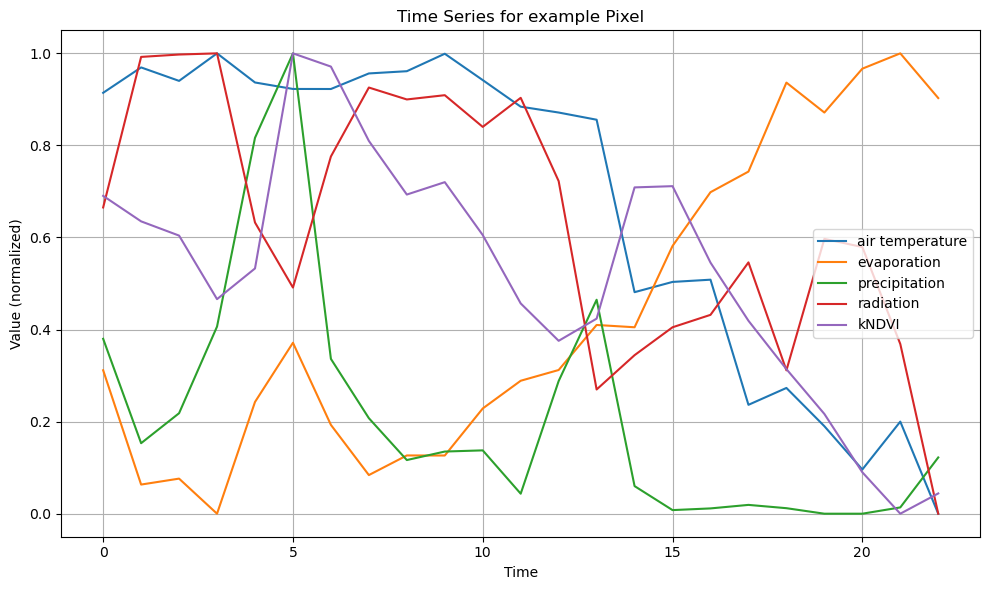

In [4]:
import matplotlib.pyplot as plt

example_series = data_sample[0,-23:,:]
normalized = (example_series - example_series.min(axis=0)) / (example_series.max(axis=0) - example_series.min(axis=0))
time = np.arange(0,23)

vars = ["air temperature", "evaporation", "precipitation", "radiation", "kNDVI"]

plt.figure(figsize=(10, 6))
for var in range(normalized.shape[1]):
    plt.plot(time, normalized[:, var], label=vars[var])


plt.xlabel('Time')
plt.ylabel('Value (normalized)')
plt.title(f'Time Series for example Pixel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nothing really clear to be seen here. In the next step, the timeseries for the kNDVI is plotted for each year separately (corresponding to a period of 46 timesteps) and overlaid. We hope to see slight overlaps or reoccuring patterns as an indicator for seasonality.

(21, 46)
(46,)


Text(0.5, 1.0, 'Overlapping yearly plot (period 46) of the kNDVI variable')

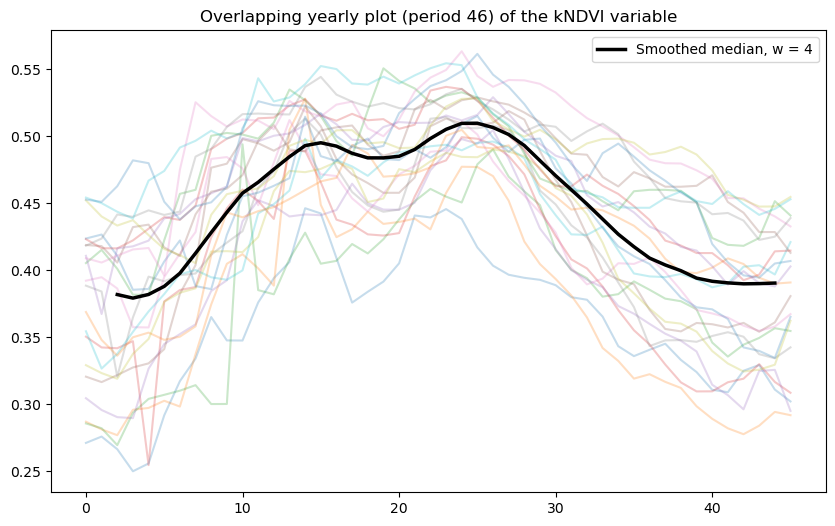

In [6]:
import pandas as pd
series = data_sample[0, :, 4]

period = 46
n_seasons = series.shape[0] // period

reshaped = series[:n_seasons * period].reshape(n_seasons, period)
print(reshaped.shape)

plt.figure(figsize=(10, 6))
for season in reshaped:
    plt.plot(season, alpha=0.25)

med = pd.Series(np.median(reshaped, axis=0)).rolling(window=4, center=True).mean()
print(med.shape)
plt.plot(med, c="black", lw=2.5, label="Smoothed median, w = 4")
plt.legend()
plt.title("Overlapping yearly plot (period 46) of the kNDVI variable")

The overlap and the median are first indicators for seasonal patterns so in the next step, we will look at the autocorrelation function (ACF) for stronger patterns. The ACF can be defined as

$$ \Psi_{xx}[m] = \sum_{n=-\infty}^{\infty} x[n] \cdot x^{*}[n - m] $$

where $ m $ is the lag and $ x^* $ is the complex conjugate of x. It test, how much a signal is correlated to itself at other points of time. To examine that, the function is plotted for the 92 lags in a single pixel, which roughly equals 2 years:

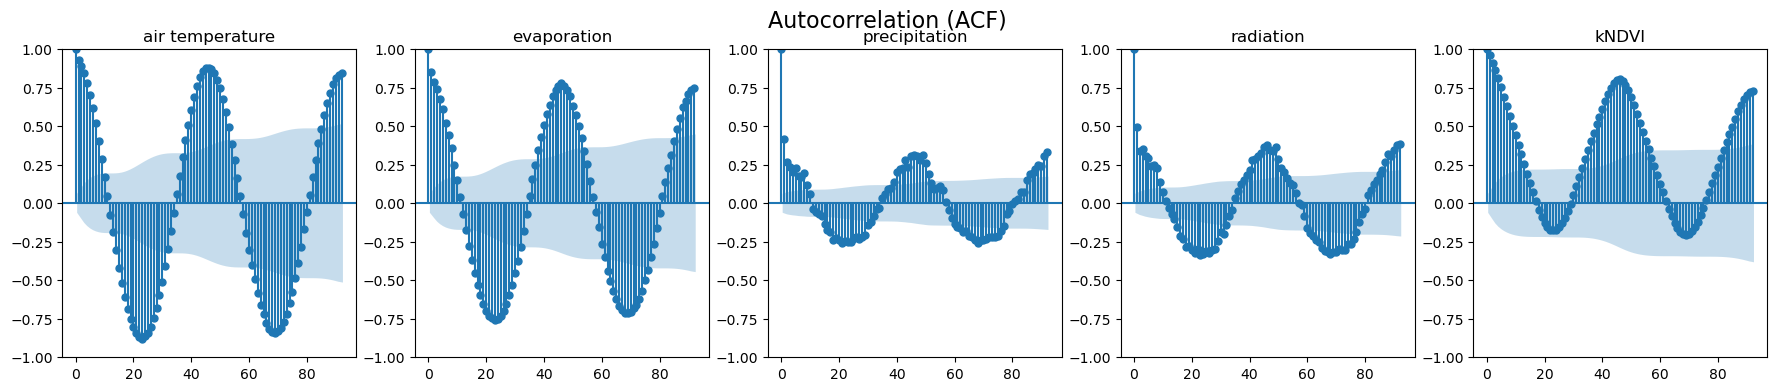

In [8]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

n_vars = data_sample.shape[2]

fig, axs = plt.subplots(1, n_vars, figsize=(22, 4))  

for var in range(n_vars):
    series = data_sample[0, :, var]
    plot_acf(series, ax=axs[var], lags=92, title=f'{vars[var]}')

plt.suptitle(f'Autocorrelation (ACF)', fontsize=16)
 
plt.show()

Some real strong patterns seem to emerge. For all variables, there seems to be a yearly cycle judging by the wave form of the function and the high correlation with values at approximately 46 and 92 timesteps, which are 1 and 2 years time. All values also seem to be correlated with their immediate predecessors, although this is a little noisy in the precipitation and radiation variable. That intuitively makes sense, as precipitation for example usually can be linked to preoccurrences ("Rain yesterday is a good indicator for rain today"), but is also strongly influenced by many other factors, whereas a green tree (kNDVI) usually is not that volatile in its signal. 


Another widely used method for seasonality analysis is the seasonal trend decomposition using LOESS (STL). As the name suggest, the signal is decomposed into three distinct constituents: Trend, Seasonal and Residuals. LOESS or LOWESS is a non-parametric approach to fit a smooth curve to data points, meaning that it does not make any assumptions about the underlying distributions in advance. Usually, LOESS approaches are composed of a weighting function composed with a polynomial fit, leading to the estimates only beeing influenced by close points, with more weight on the closest. This could be given as

$$ w(x) = (1 - |d|^3)^3 \text{ if } |d| < 1, 0 \text{ otherwise, and } \sum_i w(x_i - x_0) * [y_i - g(x_i)]^2 $$

where g(x) is typically a low-degree polynomial and the second expression minimized. Other approaches fore more robustness against outliers and multivariate scenarios are possible but not discussed here.



Text(0.5, 1.0, 'Seasonal Decomposition: kNDVI')

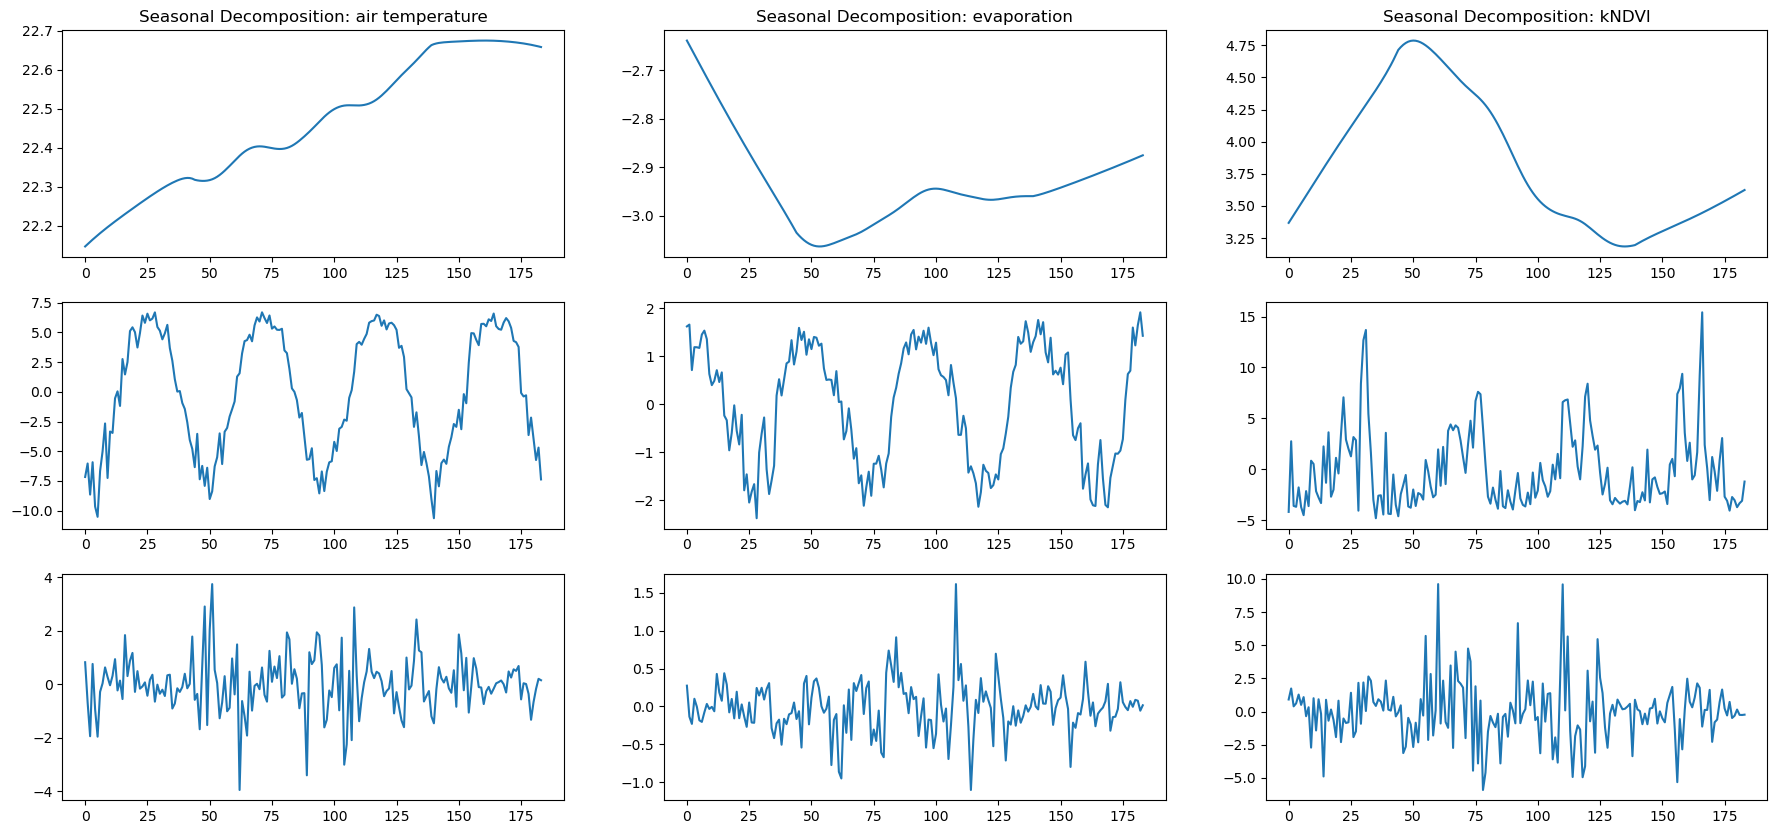

In [9]:
from statsmodels.tsa.seasonal import STL

fig, axs = plt.subplots(3, 3, figsize=(22, 10))  

for var in range(3):
    series = data_sample[0, -184:, var]
    #series = (series - np.mean(series)) / np.std(series)
    stl = STL(series, period=46)  
    res = stl.fit()
    axs[0, var].plot(res.trend)
    axs[1, var].plot(res.seasonal)
    axs[2, var].plot(res.resid)

axs[0, 0].set_title(f"Seasonal Decomposition: {vars[0]}")
axs[0, 1].set_title(f"Seasonal Decomposition: {vars[1]}")
axs[0, 2].set_title(f"Seasonal Decomposition: {vars[4]}")




This further confirms the assumption for seasonal patterns, which are more pronounced in variables like air temperature and evaporation and more noisy in precipitation for example. As a last exploratory measure, we can do a spectral analysis through a fourier tranformation, where we transform the data from the temporal to the spectral domain. This can just be a good general indicator for dominant cycles. 

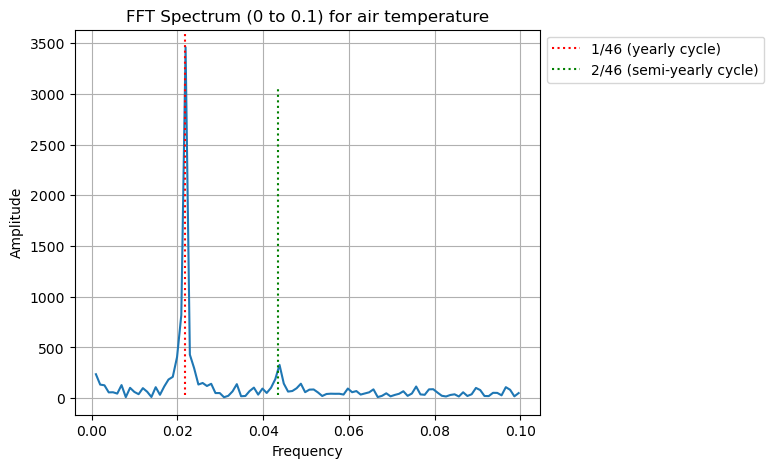

In [11]:
from scipy.fft import fft, fftfreq

series = data_sample[0, :, 0]
n = len(series)
fft_vals = np.abs(fft(series - np.mean(series)))  
freqs = fftfreq(n)


pos_mask = freqs > 0
freqs = freqs[pos_mask]
fft_vals = fft_vals[pos_mask]

range_mask = freqs <= 0.1
freqs_plot = freqs[range_mask]
fft_plot = fft_vals[range_mask]


plt.figure(figsize=(6, 5))
plt.plot(freqs_plot, fft_plot)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title(f"FFT Spectrum (0 to 0.1) for {vars[0]}")
plt.grid(True)
plt.axvline(x=1/46, color="r", ymin=0.05, ymax=1, ls=":", label="1/46 (yearly cycle)")
plt.axvline(x=1/23, color="g", ymin=0.05, ymax=0.85, ls=":", label="2/46 (semi-yearly cycle)")
plt.legend(bbox_to_anchor=(1.0, 1), loc="upper left")
plt.show()


Again, a clear peak is visible at the yearly mark and another small one for the 6 month mark. This confirms the seasonality assumption further, as it indicates, that the strongest underlying frequency has a value of 1/46, which corresponds to the 46 timesteps in a year. 


As a last exploratory measure, the cross correlation between the different variables will be examined. Cross correlation is used to determine the similarity of signals at different time lags and for discrete signals is calculated as 

$$ R_{xy}[m] = \sum_{n=-\infty}^{\infty} x[n] \cdot y^{*}[n - m] $$

where $ m $ is the lag and $ y^* $ is the complex conjugate of y. It is thus very similar to the ACF, but looking at distinct variables. In the following, cross correlation is examined for 46 lags (the duration of one year) for each variable pairing:


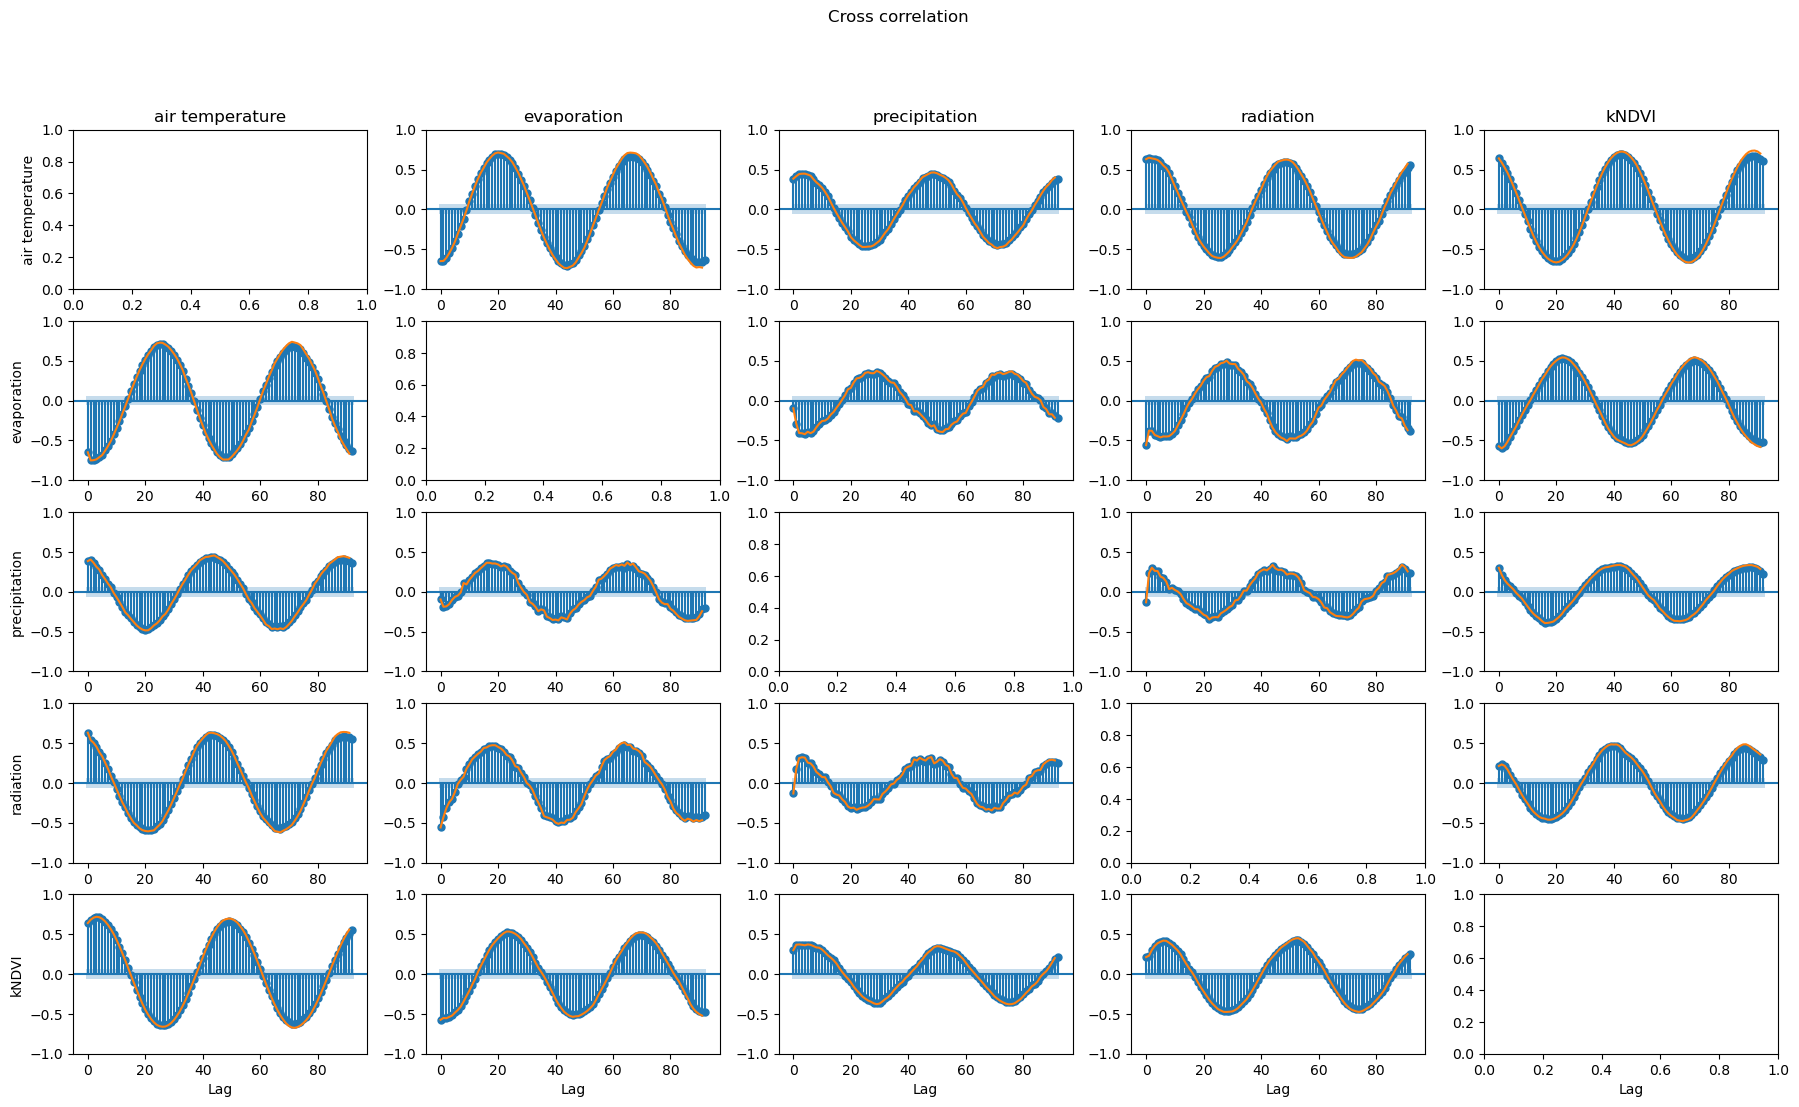

In [12]:
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_ccf



fig, axs = plt.subplots(n_vars, n_vars, figsize=(22, 12))  
fig.suptitle('Cross correlation')

for i in range(n_vars):
    for j in range(n_vars):
        axs[0, j].set_title(f"{vars[j]}")
        axs[i, 0].set(ylabel=f"{vars[i]}")
        axs[4, j].set(xlabel='Lag')
        if i != j:
            x = data_sample[1,:, i]
            x = (x - np.mean(x)) / np.std(x)
            y = data_sample[1,:, j]
            y = (y - np.mean(y)) / np.std(y)
            plot_ccf(x=x, y=y, lags=92, ax=axs[i,j], title="")
            
            cc = ccf(x=x, y=y, nlags=92)
            cc = cc
            axs[i, j].plot(cc)
            
            
          


## 3. Data Preprocessing

With all this information extracted, the next step is to prepare the data for probabilistic approaches.  The data is prepared by selecting important lags as input variables. Therefore the function "add_lag_features_with_y" is defined, which takes the data and a list of lags as input, and returns a matrix of lagged features and the corresponding response vector.




In [13]:
def add_lag_features_with_y(data, lag=range(1, 5)):

    _, timesteps, _ = data.shape

    xs = []
    ys = []

    for t in range(max(lag), timesteps):
        
        # creating lagged features
        X_t = np.concatenate([data[:, t - l, :] for l in lag], axis=1)
        # add covariates at lag = 0
        X_t = np.concatenate([data[:, t, 0:4], X_t], axis=1)
        xs.append(X_t)

        Y_t = data[:,t,4]
        ys.append(Y_t)

    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)

    return xs, ys

For simplicity purposes, for now only the highest correlations in the last two years (92 timesteps) are looked at.

In [14]:
data_sample.shape
autocorrs = acf(data_sample[1,:,4], nlags=92)
autocorrs = np.abs(autocorrs)

# choose 10 most relevant lags
high_autocorrs = np.argsort(autocorrs)[::-1]
lags = high_autocorrs[1:6]
print(lags)

# and for crosscorr
for i in range(4):
       
    crosscorr = ccf(x=data_sample[1,:,4], y=data_sample[1,:,i], nlags=92)
    crosscorr = np.abs(crosscorr)
    high_cc = np.argsort(crosscorr)[::-1]
    # remove 0 as current timestep is kept anyway in add lagged features function
    high_cc = np.delete(high_cc, np.where(high_cc == 0))
    print(f"Highest correlated lags for {vars[i]}:",high_cc[0:2])
    lags = np.concatenate([lags, high_cc[0:2]], axis=0)

lags = np.unique(lags)
lags = np.sort(lags)
print("All lags", lags)

[ 1  2  3 46 45]
Highest correlated lags for air temperature: [3 4]
Highest correlated lags for evaporation: [2 1]
Highest correlated lags for precipitation: [75 29]
Highest correlated lags for radiation: [28 74]
All lags [ 1  2  3  4 28 29 45 46 74 75]


Transformation of the data with the derived lags. The new shape for the predictors should be pixel_num * (timesteps - max(lags)),  4 + 5 * len(lags) and pixel_num * (timesteps- max(lags)) for the response vector.

In [15]:
# split in train and test (TODO: load real data later)
data_train = data_sample[:50,:,:]
data_test = data_sample[50:,:,:]
x_train, y_train = add_lag_features_with_y(data_train, lags)
print(x_train.shape)
print(y_train.shape)

(46450, 54)
(46450,)


Next, we need a function that takes in the model and iteratively predicts the value for the target variable. The scaler is added, as each time, the data needs to be scaled anew.

In [16]:
def predict_recursively(model, data, timesteps=92, lag=range(1, 5), scaler_x = None, scaler_y = None):

    _ , total_timesteps, _ = data.shape
    data_copy = data.copy()
    predictions = []

    for t in range(timesteps):
        
        target_timestep = total_timesteps - timesteps + t
        X_t = np.concatenate([data_copy[:, target_timestep - l, :] for l in lag], axis=1)
        X_t = np.concatenate([data_copy[:, target_timestep, 0:4], X_t], axis=1)
        X_t_scaled = scaler_x.transform(X_t)
        
        if np.isnan(X_t).any():
            raise ValueError(f"NaNs detected at t={t}, target_timestep={target_timestep}")


        y_pred = model.predict(X_t_scaled)
        #y_pred_scaled = model.predict(X_t_scaled)
        #y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        predictions.append(y_pred)

        data_copy[:,target_timestep, 4] = y_pred
        
    
    return np.stack(predictions, axis=1)

## 4. Probabilistic Modeling Approach

- Description of the models chosen
- Why they are suitable for your problem
- Mathematical formulations (if applicable)


First, a simple approach using bayesian ridge regression.


In [ ]:
from sklearn.linear_model import BayesianRidge

## 5. Model Training and Evaluation

- Training process
- Model evaluation (metrics, plots, performance)
- Cross-validation or uncertainty quantification



## 6. Results

- Present key findings
- Comparison of models if multiple approaches were used



## 7. Discussion

- Interpretation of results
- Limitations of the approach
- Possible improvements or extensions



## 8. Conclusion

- Summary of main outcomes



## 9. References

- Cite any papers, datasets, or tools used